Importaciones 

In [43]:
from tensorflow import keras
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Establecer semilla para reproducibilidad
set_random_seed(42)

Cargar imágenes de entrenamiento

In [35]:
# Generador de imágenes con separación de validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% de las imágenes de entrenamiento se usarán para validación
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Cargar imágenes de entrenamiento (80% de train/)
train_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\cesar_v8v3xol\Downloads\TensorFlow-Pet-Classifier-main\data\train",
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset="training"  # Indicar que son imágenes de entrenamiento
)

# Cargar imágenes de validación (20% de train/)
validation_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\cesar_v8v3xol\Downloads\TensorFlow-Pet-Classifier-main\data\train",
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset="validation"  # Indicar que son imágenes de validación
)


Found 17624 images belonging to 2 classes.
Found 4406 images belonging to 2 classes.


Definir el Modelo 

In [36]:
# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPool2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Clasificación binaria (perro o gato)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Definir Callbacks

In [37]:
# Callbacks para mejorar el entrenamiento
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

Entrenar el Modelo

In [38]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/10
551/551 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.6350
Epoch 1: val_accuracy improved from -inf to 0.71630, saving model to best_model.h5
551/551 [==============================] - 394s 713ms/step - loss: 0.6432 - accuracy: 0.6350 - val_loss: 0.5538 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 2/10
551/551 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7207
Epoch 2: val_accuracy improved from 0.71630 to 0.76487, saving model to best_model.h5
551/551 [==============================] - 392s 711ms/step - loss: 0.5523 - accuracy: 0.7207 - val_loss: 0.4869 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 3/10
551/551 [==============================] - ETA: 0s - loss: 0.4946 - accuracy: 0.7631
Epoch 3: val_accuracy improved from 0.76487 to 0.78234, saving model to best_model.h5
551/551 [==============================] - 394s 716ms/step - loss: 0.4946 - accuracy: 0.7631 - val_loss: 0.4560 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 4/10
55

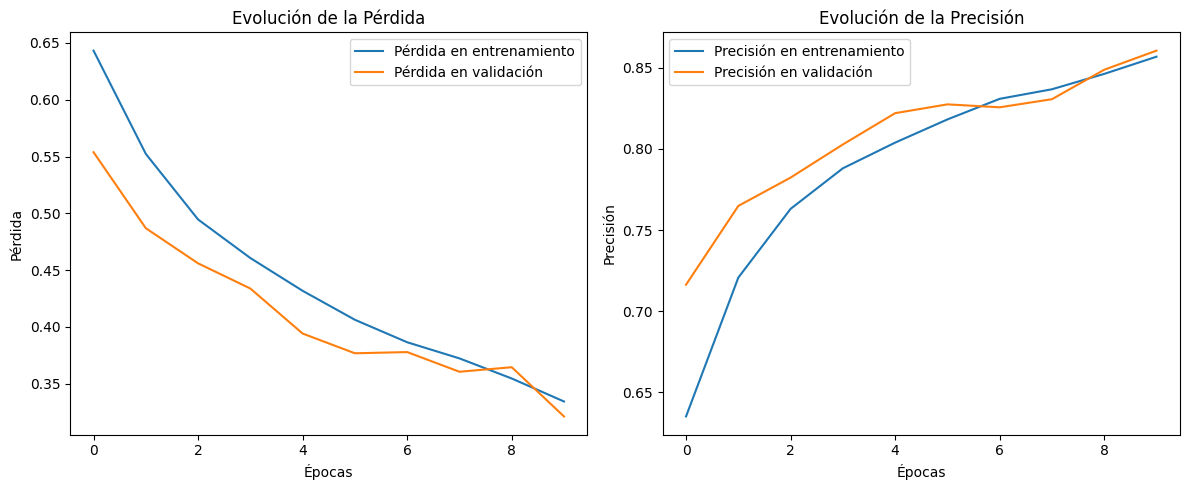

In [39]:

# Extraer métricas del entrenamiento
history_dict = history.history
epochs_range = range(len(history_dict['loss']))

# Crear la figura
plt.figure(figsize=(12, 5))

# Gráfica de la pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict['loss'], label='Pérdida en entrenamiento')
plt.plot(epochs_range, history_dict['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')

# Gráfica de la precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict['accuracy'], label='Precisión en entrenamiento')
plt.plot(epochs_range, history_dict['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')

# Mostrar la figura
plt.tight_layout()
plt.show()


Evaluar el Modelo

1/1 [==============================] - 0s 33ms/step


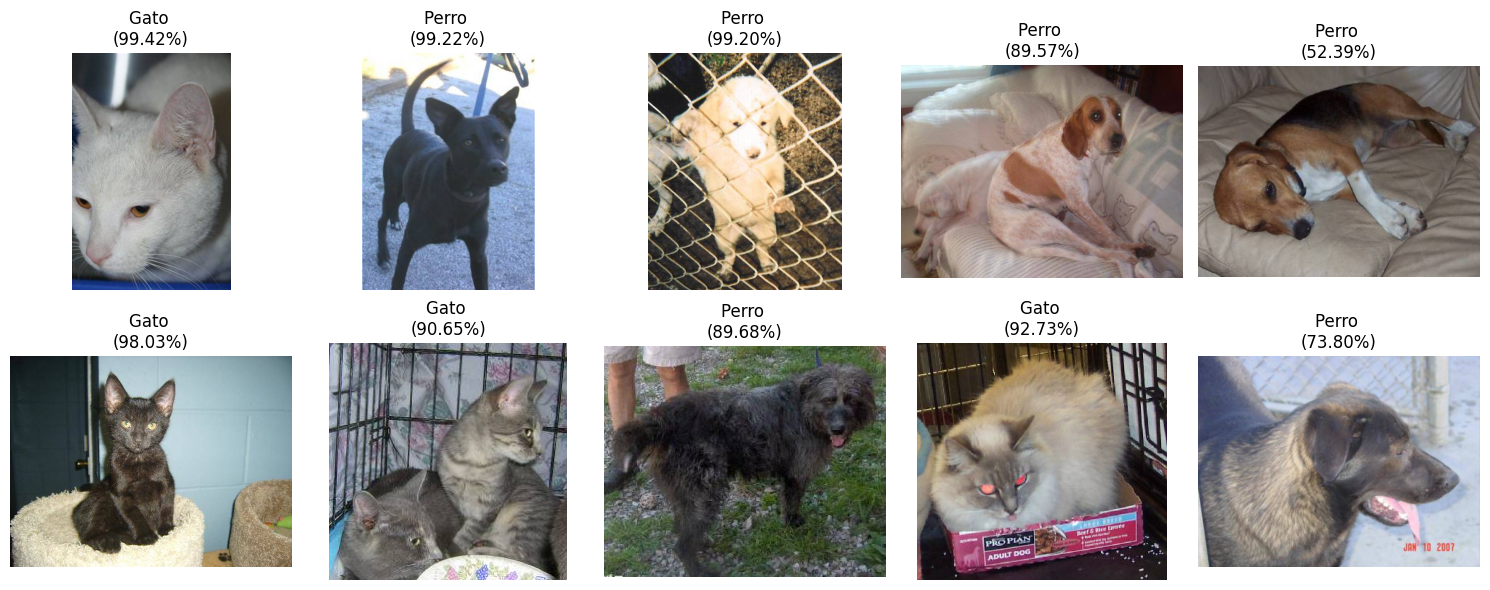

In [54]:
# Función para predecir y mostrar múltiples imágenes
def predict_and_plot_grid(model, img_paths, threshold=0.5):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 filas, 5 columnas
    
    for ax, img_path in zip(axes.flatten(), img_paths):
        img = image.load_img(img_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        pred_label = "Perro " if prediction[0][0] > threshold else "Gato "
        prob = float(prediction[0][0]) if pred_label == "Perro " else 1 - float(prediction[0][0])

        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        ax.imshow(img_rgb)
        ax.set_title(f"{pred_label}\n({prob*100:.2f}%)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Evaluar 10 imágenes aleatorias de prueba
test_directory = r"C:\Users\cesar_v8v3xol\Downloads\TensorFlow-Pet-Classifier-main\data\test"
test_images = [os.path.join(test_directory, fname) for fname in os.listdir(test_directory) if fname.endswith('.jpg') or fname.endswith('.png')]

# Seleccionar 10 imágenes aleatorias
random_images = np.random.choice(test_images, 10, replace=False)
predict_and_plot_grid(model, random_images)
